In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2
import calendar
import random
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

### Note : Cancelled orders shouldn't be considered for the analysis.

In [2]:
conn = psycopg2.connect(
    host='shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com',
    port='5432',
    user='toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c',
    password='toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_password',
    database='toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_db'
)

In [3]:
query1 = """select o.id as order_id,
            o.created_at::date as order_date,
            o.customer_id as user_id,
            oli.product_id as product_id,
            o.total_price as order_amount,
            oli.name as product_name,
            CASE
        WHEN cancelled_at IS NOT NULL THEN 'Cancelled'
         ELSE 'Delivered'
     END as order_status,
            oli.quantity as quantity,
            oli.price as sp
            from orders o
            join order_line_item oli on oli.order_id = o.id"""

In [4]:
data = pd.read_sql(query1, conn)

In [5]:
data["order_date"] = pd.to_datetime(data["order_date"])

In [6]:
data['WeekCount']=data['order_date'].dt.strftime('%y-w%U')

In [7]:
data = data.dropna()

In [8]:
#data = data[data['order_date'] >= '2021-01-01']

In [9]:
data=data.sort_values('order_date')
WeekList=data['WeekCount'].unique()

In [10]:
#data = data[data['order_date'] <= '2023-06-30']

In [11]:
WeekList = WeekList.tolist()
output_list = []

for i in range(len(WeekList) - 1):
    output_list.append(WeekList[i])
    current_week = int(WeekList[i].split('-w')[1])
    next_week = int(WeekList[i + 1].split('-w')[1])
    missing_weeks = next_week - current_week - 1
    for j in range(1, missing_weeks + 1):
        missing_week = current_week + j
        output_list.append(f'{WeekList[i][:5]}w{missing_week:02d}')

output_list.append(WeekList[-1])

In [12]:
orderuserlevel=data.groupby(['order_id','user_id']).agg(
          order_date=pd.NamedAgg(column='order_date', aggfunc='min'),

    ).reset_index()
orderuserlevel=orderuserlevel.sort_values('order_date')
orderuserlevel['TrxnRank'] = orderuserlevel.groupby('user_id')['order_date'].rank(method='first')
orderuserlevel


data=pd.merge(data,
         orderuserlevel[['order_id','TrxnRank']],
         on="order_id",
         how ='left')
data['New']=0
data['Repeat']=0
data.loc[data['TrxnRank']==1,'New']=1
data.loc[data['TrxnRank']>1,'Repeat']=1

#AOV Contribution
data['ordervalue']=data['quantity']*data['sp']
data['AOVContribution']=data['ordervalue']/data["order_id"].nunique()
data['DeltaDaysinOrders']=(data.groupby('user_id').order_date.shift() - data.order_date).dt.days.abs()
data['DeltaOrderValues']=(data.groupby('user_id').ordervalue.shift() - data.ordervalue)

In [13]:
data = data[data['order_status'] != 'Cancelled']

In [14]:
avg_delta_days = data["DeltaDaysinOrders"].mean() # change
weeklyusersegsats = {}
for x in output_list:
  x3 = data[data['WeekCount'] <= x]
  try:
    userweeklydata = x3.groupby("user_id").agg(
          Last_Date=pd.NamedAgg(column='order_date', aggfunc= lambda x: x.nlargest(1).min()),
          First_Date=pd.NamedAgg(column='order_date', aggfunc='min'),
          OrdersCount=pd.NamedAgg(column='order_id', aggfunc='nunique'),
          Frequency=pd.NamedAgg(column='order_id', aggfunc='nunique'),
          Order_Value=pd.NamedAgg(column='ordervalue', aggfunc='sum'),
          Mean_Days_Delta=pd.NamedAgg(column='DeltaDaysinOrders', aggfunc='mean'),
          Mean_OV_Delta=pd.NamedAgg(column='DeltaOrderValues', aggfunc='mean')
          ).reset_index()

    globalmaxdateweek=x3['order_date'].max()
    userweeklydata['Recency']=globalmaxdateweek-userweeklydata['Last_Date']
    userweeklydata['Recency']=userweeklydata['Recency'].dt.days.abs()
    userweeklydata['Activated_Quater']=userweeklydata['First_Date'].dt.to_period('Q')
    userweeklydata['MaturityAge']=np.nan
    userweeklydata.loc[userweeklydata['Frequency']>1,"MaturityAge"]=(userweeklydata['Last_Date']-userweeklydata['First_Date']).dt.days.abs()
    userweeklydata['Mean_Days_Delta']=userweeklydata['Mean_Days_Delta'].fillna(0)
    userweeklydata['Mean_OV_Delta']=userweeklydata['Mean_OV_Delta'].fillna(0)
    userweeklydata['Customer_AOV']=userweeklydata['Order_Value']/userweeklydata['OrdersCount']

    r_labels, f_labels,AOV_labels, m_labels,DelAOV_labels = range(4, 0, -1), range(1,5), range(1,5),range(1,5),range(1,5)
    userweeklydata['f_score'] = userweeklydata['OrdersCount'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = f_labels)).astype('int64')
    userweeklydata['r_score'] = userweeklydata['Recency'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = r_labels)).astype('int64')
    userweeklydata['AOV_score'] = userweeklydata['Customer_AOV'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = AOV_labels)).astype('int64')
    userweeklydata['m_score']=0
    userweeklydata.loc[userweeklydata['MaturityAge'].notnull(),'m_score']= userweeklydata.loc[userweeklydata['MaturityAge'].notnull()]['MaturityAge'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = m_labels)).astype('int64')
    userweeklydata['DelAOV'] = userweeklydata['Mean_OV_Delta'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = DelAOV_labels)).astype('int64')
    userweeklydata['SumScore'] = userweeklydata['r_score'] + userweeklydata['m_score'] + userweeklydata['AOV_score']+ userweeklydata['DelAOV'] +userweeklydata['f_score']

    def CohortLables_3(df):
      if ((df['Frequency']==1) & (df['r_score']>2)):
          return "New"
      elif ((df['Frequency'] == 1) & (df['r_score'] <= 2)):
          return 'Churned (Single Use Only)'
      elif ((df['Frequency'] > 1) & (df['m_score'] < 3) & (df['r_score'] >2)):
          return 'Recent & Loyals'
      elif ((df['Frequency'] > 1) & (df['m_score'] >=2) & (df['Recency'] <= avg_delta_days)): # change is there
          return 'Champions'
      else:
          return 'Churned (Repeat Use)'
    userweeklydata['CohortLabel'] = userweeklydata.apply(CohortLables_3, axis=1)

    usersegstats=userweeklydata.groupby(
      'CohortLabel'
    ).agg(
          Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
          Orders=pd.NamedAgg(column='OrdersCount', aggfunc='sum'),
          Recency=pd.NamedAgg(column='Recency', aggfunc='mean'),
          OrderValue=pd.NamedAgg(column='Order_Value', aggfunc='sum'),
          MeanDaysDelta=pd.NamedAgg(column='Mean_Days_Delta', aggfunc='mean'),
          MeanOVDelta=pd.NamedAgg(column='Mean_OV_Delta', aggfunc='mean'),
          Maturity=pd.NamedAgg(column='MaturityAge', aggfunc='mean'),
    )

    usersegstats["Frequency"] = usersegstats["Orders"] / usersegstats["Users"]
    usersegstats["AOVContribution"] = usersegstats["OrderValue"] / usersegstats["Orders"].sum()
    usersegstats["AOV"] = usersegstats["OrderValue"] / usersegstats["Orders"]
    user_cohort_labels = ['New', 'Churned (Single Use Only)', 'Recent & Loyals', 'Champions', 'Churned (Repeat Use)']
    var_list = ['Users', 'Orders', 'Recency', 'AOVContribution', 'OrderValue','MeanDaysDelta', 'MeanOVDelta', 'Maturity', 'Frequency', 'AOV']
    dummy_df = pd.DataFrame(index=user_cohort_labels, columns=var_list)
    for i in user_cohort_labels:
      try:
        dummy_df.loc[i] = usersegstats.loc[i]
      except:
        pass
    dummy_df = dummy_df.fillna(0)
    usersegstats = dummy_df
    print(usersegstats)
    weeklyusersegsats[x] = usersegstats
  except:
    pass

                           Users  Orders   Recency  AOVContribution  \
New                        306.0   306.0  1.486928       270.523810   
Churned (Single Use Only)  328.0   328.0  2.658537       289.727891   
Recent & Loyals             12.0    25.0  1.500000        22.108844   
Champions                   24.0    66.0  1.750000        66.930612   
Churned (Repeat Use)         4.0    10.0  2.000000         8.843537   

                           OrderValue  MeanDaysDelta  MeanOVDelta  Maturity  \
New                          198835.0       0.000000     0.000000  0.000000   
Churned (Single Use Only)    212950.0       0.000000     0.000000  0.000000   
Recent & Loyals               16250.0       0.000000     0.000000  0.000000   
Champions                     49194.0       1.171627     6.244048  1.291667   
Churned (Repeat Use)           6500.0       0.000000     0.000000  0.000000   

                           Frequency         AOV  
New                         1.000000  649.78758

In [15]:
usersegstats

,Users,Orders,Recency,AOVContribution,OrderValue,MeanDaysDelta,MeanOVDelta,Maturity,Frequency,AOV
New,17084.0,17084.0,103.718157,131.213049,8172736.0,0.003073,-1.877288,0.000000,1.000000,478.385390
Churned (Single Use Only),18684.0,18684.0,558.982712,326.468596,20334423.0,0.028246,3.324374,0.000000,1.000000,1088.333494
Recent & Loyals,2401.0,5480.0,89.380258,51.759786,3223910.0,16.740298,-39.105320,23.949188,2.282382,588.304745
Champions,567.0,2992.0,18.649030,66.190284,4122728.0,84.882993,-17.645088,339.613757,5.276896,1377.917112
Churned (Repeat Use),5608.0,18046.0,367.702924,397.796535,24777155.0,71.464296,-33.342443,220.314907,3.217903,1372.999834


In [16]:
userweeklydata[userweeklydata['CohortLabel']=='Recent & Loyals']

,user_id,Last_Date,First_Date,OrdersCount,Frequency,Order_Value,Mean_Days_Delta,Mean_OV_Delta,Recency,Activated_Quater,MaturityAge,Customer_AOV,f_score,r_score,AOV_score,m_score,DelAOV,SumScore,CohortLabel
1895,3.660581e+12,2023-06-28,2023-06-28,2,2,3490.0,0.000000,133.333333,176,2023Q2,0.0,1745.000000,4,3,4,1,4,16,Recent & Loyals
2438,3.685691e+12,2023-07-07,2023-07-07,2,2,2297.0,0.000000,33.333333,167,2023Q3,0.0,1148.500000,4,3,3,1,4,15,Recent & Loyals
3358,5.057566e+12,2023-09-11,2023-07-26,3,3,3695.0,9.400000,-16.000000,101,2023Q3,47.0,1231.666667,4,3,4,2,1,14,Recent & Loyals
3369,5.058281e+12,2023-07-29,2023-06-20,2,2,2470.0,39.000000,-130.000000,145,2023Q2,39.0,1235.000000,4,3,4,2,1,14,Recent & Loyals
4471,5.149082e+12,2023-07-28,2023-06-24,2,2,5139.0,11.333333,-103.333333,146,2023Q2,34.0,2569.500000,4,3,4,2,1,14,Recent & Loyals
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44162,6.955885e+12,2023-12-15,2023-12-15,3,3,797.0,0.000000,50.000000,6,2023Q4,0.0,265.666667,4,4,1,1,4,14,Recent & Loyals
44193,6.956044e+12,2023-12-15,2023-12-15,2,2,1730.0,0.000000,-470.000000,6,2023Q4,0.0,865.000000,4,4,3,1,1,13,Recent & Loyals
44246,6.958520e+12,2023-12-18,2023-12-16,2,2,498.0,2.000000,-100.000000,3,2023Q4,2.0,249.000000,4,4,1,1,1,11,Recent & Loyals
44247,6.958529e+12,2023-12-16,2023-12-16,2,2,498.0,0.000000,100.000000,5,2023Q4,0.0,249.000000,4,4,1,1,4,14,Recent & Loyals


In [17]:
weeklyusersegsats['23-w35']

,Users,Orders,Recency,AOVContribution,OrderValue,MeanDaysDelta,MeanOVDelta,Maturity,Frequency,AOV
New,12910.0,12910.0,105.099380,221.710354,10407084.0,0.002014,1.651219,0.000000,1.000000,806.125794
Churned (Single Use Only),14240.0,14240.0,528.525492,326.142203,15309115.0,0.036078,1.455018,0.000000,1.000000,1075.078301
Recent & Loyals,1696.0,3874.0,108.287736,92.770409,4354643.0,16.965746,-41.345708,33.931604,2.284198,1124.068921
Champions,430.0,2257.0,21.144186,72.031274,3381148.0,72.268406,-13.544361,357.581395,5.248837,1498.071777
Churned (Repeat Use),4200.0,13659.0,342.276190,404.428441,18983871.0,75.099967,-28.852186,227.641667,3.252143,1389.843400


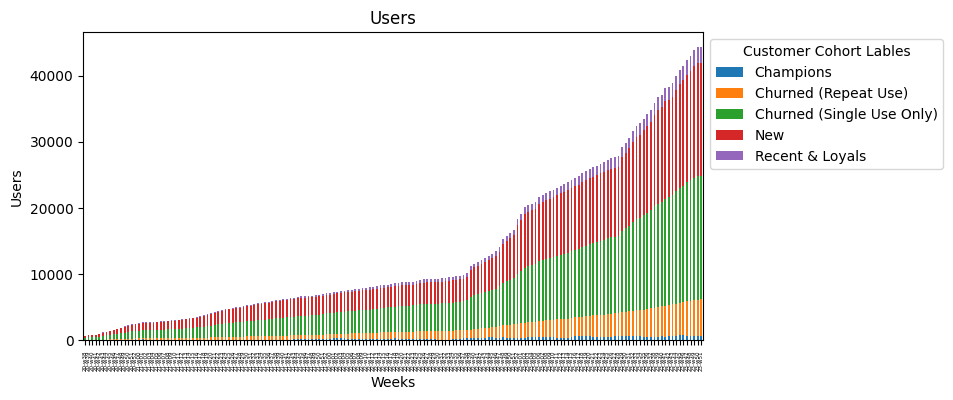

In [31]:
each_metric_df = {}
ListofCustomerCohortVariables = usersegstats.columns.to_list()
Line_Chart_Variable_List_Customer = ['Recency', 'OrderValue', 'MeanDaysDelta', 'MeanOVDelta', 'Maturity', 'Frequency', 'AOV']
Stack_Chart_Variable_List_Customer = ['Users', 'Orders', 'AOVContribution']
user_cohort_labels = ['Champions', 'Churned (Repeat Use)', 'Churned (Single Use Only)', 'New', 'Recent & Loyals']
for week, df in weeklyusersegsats.items():
    df.sort_index(inplace=True)


def metric_graph(metric):
    if metric in Line_Chart_Variable_List_Customer:
        column_df = pd.DataFrame({week: df[metric].tolist() for week, df in weeklyusersegsats.items()})
        column_df.index = user_cohort_labels
        column_transposed = column_df.transpose()
        insights_table = column_transposed
        # print(Line_Chart_Table)
        each_metric_df[metric] = column_transposed
        weeks = column_transposed.index.to_list()

        for column_name, values in column_transposed.items():
            # Skip plotting if any value in the column is zero
            if not all(value == 0 for value in values):
                plt.plot(weeks, values, label=column_name)

        plt.xlabel('Weeks')
        plt.ylabel(metric)
        plt.title(f'{metric}')
        plt.xticks(fontsize=4, rotation=90)
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Customer Cohort Labels')
        plt.show()

    if metric in Stack_Chart_Variable_List_Customer:
      variable_df = pd.DataFrame({week: df[metric].tolist() for week, df in weeklyusersegsats.items()})
      variable_df.index = user_cohort_labels
      variable_df_transposed = variable_df.transpose()
      each_metric_df[metric] = variable_df_transposed
      insights_table = variable_df_transposed
      # print(Stack_Chart_Table)
      variable_df_transposed.plot(kind='bar', stacked=True, figsize=(8, 4))
      plt.title(f'{metric}')
      plt.xticks(fontsize=4)
      plt.xlabel('Weeks')
      plt.ylabel(metric)
      plt.legend(loc='upper left', bbox_to_anchor=(1,1), title = 'Customer Cohort Lables')
      plt.show()
    return insights_table

# result = metric_graph('Recency')
# result_1 = metric_graph('MeanDaysDelta')
# result_2 = metric_graph('OrderValue')
# result_3 = metric_graph('MeanOVDelta')
# result_4 = metric_graph('Maturity')
# result_5 = metric_graph('Frequency')
# result_6 = metric_graph('AOV')
result_7 = metric_graph('Users')
# result_8 = metric_graph('Orders')
# result_9 = metric_graph('AOVContribution')

In [19]:
# file_path = 'output.xlsx'

# with pd.ExcelWriter(file_path) as writer:
#     startrow = 0
#     for dataframe in [result, result_1, result_2, result_3, result_4, result_5, result_6, result_7, result_8, result_9]:
#         dataframe.to_excel(writer, sheet_name='Sheet1', startrow=startrow, startcol=0, index=False)
#         startrow += dataframe.shape[0] + 1


In [20]:
result

,Champions,Churned (Repeat Use),Churned (Single Use Only),New,Recent & Loyals
20-w38,1.750000,2.000000,2.658537,1.486928,1.500000
20-w39,4.416667,9.000000,9.576000,6.773994,7.230769
20-w40,11.416667,16.000000,16.552430,12.648968,14.230769
20-w41,16.702703,23.000000,23.526829,17.641243,19.137931
20-w42,21.044444,30.000000,30.442765,18.070000,21.250000
...,...,...,...,...,...
23-w47,17.731044,367.199264,545.067238,94.115156,84.729574
23-w48,16.929356,364.969908,547.667982,95.377520,85.117137
23-w49,17.590343,366.644280,549.849900,95.811200,84.608195
23-w50,17.607908,366.742331,554.436204,99.293622,86.146997


In [21]:
result_1

,Champions,Churned (Repeat Use),Churned (Single Use Only),New,Recent & Loyals
20-w38,1.171627,0.000000,0.000000,0.000000,0.000000
20-w39,4.359788,0.000000,0.000000,0.000000,1.413462
20-w40,4.359788,0.000000,0.000000,0.000000,1.413462
20-w41,4.862613,0.000000,0.000000,0.000000,1.353448
20-w42,7.322658,0.000000,0.000000,0.000000,1.132812
...,...,...,...,...,...
23-w47,82.989356,71.313966,0.029350,0.001320,17.032827
23-w48,81.378721,71.636007,0.028934,0.001301,17.014494
23-w49,84.859904,71.327180,0.028495,0.002696,16.861430
23-w50,83.447538,71.376501,0.028281,0.003075,16.742498


In [22]:
result_2

,Champions,Churned (Repeat Use),Churned (Single Use Only),New,Recent & Loyals
20-w38,49194.0,6500.0,212950.0,198835.0,16250.0
20-w39,99559.0,14300.0,243500.0,296732.0,47244.0
20-w40,99559.0,14300.0,253900.0,334197.0,47244.0
20-w41,104658.0,15600.0,266250.0,351284.0,55990.0
20-w42,125680.0,16900.0,300635.0,394680.0,67583.0
...,...,...,...,...,...
23-w47,4520153.0,23192008.0,19486223.0,8556872.0,3430108.0
23-w48,4183691.0,23851023.0,19730956.0,8453304.0,3396687.0
23-w49,4195998.0,24230706.0,20078559.0,8317638.0,3316639.0
23-w50,4263459.0,24524542.0,20291109.0,8190419.0,3232026.0


In [23]:
result_3

,Champions,Churned (Repeat Use),Churned (Single Use Only),New,Recent & Loyals
20-w38,6.244048,0.000000,0.000000,0.000000,0.000000
20-w39,-894.286376,0.000000,0.000000,0.000000,-171.471154
20-w40,-894.286376,0.000000,0.000000,-3.020649,-171.471154
20-w41,-874.970721,0.000000,0.000000,-2.892655,-135.646552
20-w42,-737.617429,0.000000,0.000000,-2.360000,-60.492188
...,...,...,...,...,...
23-w47,-19.522846,-28.152675,2.541046,-0.652857,-55.194503
23-w48,-22.725448,-31.244888,3.011543,-1.220589,-48.336828
23-w49,-7.885983,-34.981276,3.324979,-1.667285,-41.227962
23-w50,-11.406582,-33.774243,3.330892,-1.727362,-40.340700


In [24]:
result_4

,Champions,Churned (Repeat Use),Churned (Single Use Only),New,Recent & Loyals
20-w38,1.291667,0.000000,0.0,0.0,0.000000
20-w39,5.055556,0.000000,0.0,0.0,1.769231
20-w40,5.055556,0.000000,0.0,0.0,1.769231
20-w41,6.243243,0.000000,0.0,0.0,1.758621
20-w42,8.622222,0.000000,0.0,0.0,1.531250
...,...,...,...,...,...
23-w47,313.635193,222.098954,0.0,0.0,25.438277
23-w48,314.211931,222.826218,0.0,0.0,25.121909
23-w49,316.760125,221.562177,0.0,0.0,24.679898
23-w50,331.828666,219.948575,0.0,0.0,23.975640


In [25]:
result_5

,Champions,Churned (Repeat Use),Churned (Single Use Only),New,Recent & Loyals
20-w38,2.750000,2.500000,1.0,1.0,2.083333
20-w39,2.416667,2.750000,1.0,1.0,2.423077
20-w40,2.416667,2.750000,1.0,1.0,2.423077
20-w41,2.513514,2.666667,1.0,1.0,2.413793
20-w42,2.533333,2.600000,1.0,1.0,2.406250
...,...,...,...,...,...
23-w47,4.690987,3.243222,1.0,1.0,2.268206
23-w48,4.775510,3.248072,1.0,1.0,2.272885
23-w49,4.845794,3.234871,1.0,1.0,2.277422
23-w50,5.168040,3.212017,1.0,1.0,2.278454


In [26]:
result_6

,Champions,Churned (Repeat Use),Churned (Single Use Only),New,Recent & Loyals
20-w38,745.363636,650.000000,649.237805,649.787582,650.000000
20-w39,1144.356322,650.000000,649.333333,918.674923,749.904762
20-w40,1144.356322,650.000000,649.360614,985.831858,749.904762
20-w41,1125.354839,650.000000,649.390244,992.327684,799.857143
20-w42,1102.456140,650.000000,649.319654,986.700000,877.701299
...,...,...,...,...,...
23-w47,1378.515706,1384.762837,1083.711863,525.251489,671.516836
23-w48,1375.309336,1381.066763,1081.741009,511.670238,648.346440
23-w49,1348.761813,1382.005704,1084.096917,492.897067,621.559033
23-w50,1359.087982,1377.705859,1087.353786,479.729339,595.765161


In [27]:
result_7

,Champions,Churned (Repeat Use),Churned (Single Use Only),New,Recent & Loyals
20-w38,24.0,4.0,328.0,306.0,12.0
20-w39,36.0,8.0,375.0,323.0,26.0
20-w40,36.0,8.0,391.0,339.0,26.0
20-w41,37.0,9.0,410.0,354.0,29.0
20-w42,45.0,10.0,463.0,400.0,32.0
...,...,...,...,...,...
23-w47,699.0,5164.0,17981.0,16291.0,2252.0
23-w48,637.0,5317.0,18240.0,16521.0,2305.0
23-w49,642.0,5420.0,18521.0,16875.0,2343.0
23-w50,607.0,5542.0,18661.0,17073.0,2381.0


In [28]:
result_8

,Champions,Churned (Repeat Use),Churned (Single Use Only),New,Recent & Loyals
20-w38,66.0,10.0,328.0,306.0,25.0
20-w39,87.0,22.0,375.0,323.0,63.0
20-w40,87.0,22.0,391.0,339.0,63.0
20-w41,93.0,24.0,410.0,354.0,70.0
20-w42,114.0,26.0,463.0,400.0,77.0
...,...,...,...,...,...
23-w47,3279.0,16748.0,17981.0,16291.0,5108.0
23-w48,3042.0,17270.0,18240.0,16521.0,5239.0
23-w49,3111.0,17533.0,18521.0,16875.0,5336.0
23-w50,3137.0,17801.0,18661.0,17073.0,5425.0


In [29]:
result_9

,Champions,Churned (Repeat Use),Churned (Single Use Only),New,Recent & Loyals
20-w38,66.930612,8.843537,289.727891,270.523810,22.108844
20-w39,114.435632,16.436782,279.885057,341.071264,54.303448
20-w40,110.375831,15.853659,281.485588,370.506652,52.376940
20-w41,110.050473,16.403785,279.968454,369.383807,58.874869
20-w42,116.370370,15.648148,278.365741,365.444444,62.576852
...,...,...,...,...,...
23-w47,76.087885,390.391839,328.012238,144.038110,57.739122
23-w48,69.367472,395.460655,327.148097,140.159570,56.318593
23-w49,68.365452,394.791221,327.140234,135.519389,54.038044
23-w50,68.658051,394.939240,326.764723,131.897177,52.048022


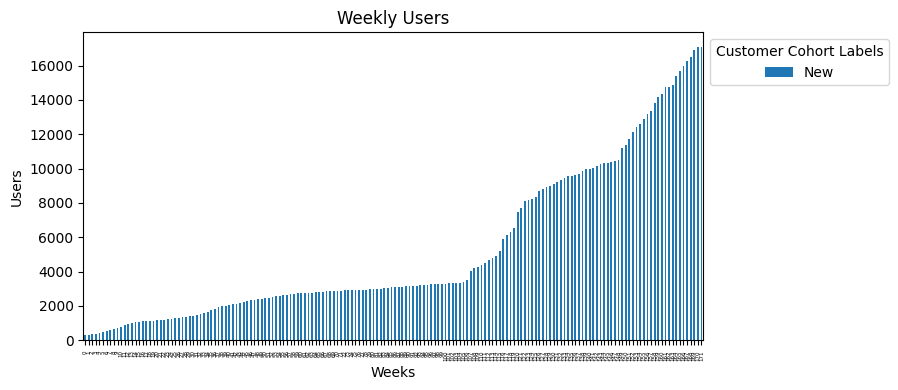

In [30]:
def metric_cohort_graph(metric, cohort):
    if metric in Line_Chart_Variable_List_Customer:
        column_df = pd.DataFrame({week: df[metric].tolist() for week, df in weeklyusersegsats.items()})
        column_df.index = user_cohort_labels
        column_transposed = column_df.transpose()
        each_metric_df[metric] = column_transposed[cohort]  # Select only the specified cohort column

        # Replace zero values with np.nan
        each_metric_df[metric] = np.where(each_metric_df[metric] == 0, np.nan, each_metric_df[metric])

        plt.plot(column_transposed.index, each_metric_df[metric], label=cohort)
        plt.xlabel('Weeks')
        plt.ylabel(metric)
        plt.title(f'Weekly {metric}')
        plt.xticks(fontsize=4, rotation=90)
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Customer Cohort Labels')
        plt.show()

    if metric in Stack_Chart_Variable_List_Customer:
        variable_df = pd.DataFrame({week: df[metric].tolist() for week, df in weeklyusersegsats.items()})
        variable_df.index = user_cohort_labels
        variable_df_transposed = variable_df.transpose()
        each_metric_df[metric] = variable_df_transposed[cohort]  # Select only the specified cohort column

        # Replace zero values with np.nan
        each_metric_df[metric] = np.where(each_metric_df[metric] == 0, np.nan, each_metric_df[metric])

        graph2 = pd.DataFrame({cohort: each_metric_df[metric]})
        graph2.plot(kind='bar', stacked=True, figsize=(8, 4))
        plt.title(f'Weekly {metric}')
        plt.xticks(fontsize=4)
        plt.xlabel('Weeks')
        plt.ylabel(metric)
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Customer Cohort Labels')
        plt.show()

# Call the function with the specified metric and cohort
output = metric_cohort_graph('Users', 'New')
